<a href="https://colab.research.google.com/github/bbandbass/Study/blob/main/chp3_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 추론 기반 기법과 신경망
통계 기반 기법에서는 주변 단어의 빈도를 기초로 하여 동시발생 행렬을 만들고, 그 행렬에 SVD를 적용하여 밀집벡터(단어의 분산 표현)을 얻어서 사용했다.   
하지만, 이런 방식은 대규모 말뭉치를 다룰 때 거대 행렬에 SVD를 적용하는 일은 현실적이지 않다.  
추론 기법이란, 주변 단어를 이용하여 특정 단어를 추측하는 학습 과정을 반복적으로 진행하여 단어의 출현 패턴을 학습하는 것이다. 

In [1]:
import numpy as np

c = np.array([1, 0, 0, 0, 0, 0, 0]) # input
W = np.random.randn(7, 3) # weight, 7 크기의 oh vector를 input으로 받아 크기 3의 벡터를 출력한다
h = np.matmul(c, W)
print(h)

[0.62119497 1.28161742 2.00871147]


이 때, oh vector는 단어 id에 대응하는 원소만 1이고, 그 외는 모두 0이기 때문에 h(c와 W의 행렬곱)은 결국 가중치의 행 벡터(단어 id번째)를 하나 뽑아낸 것과 동일하다. 따라서, 행렬 곱을 계산하는 것이 비효율적이기 때문에, 이를 나중에 개선하여 사용한다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import sys
sys.path.append('..')
%cd /content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common
from common.layers import MatMul

c = np.array([1, 0, 0, 0, 0, 0, 0]) # input
W = np.random.randn(7, 3) # weight, 7 크기의 oh vector를 input으로 받아 크기 3의 벡터를 출력한다
layer = MatMul(W)
h = layer.forward(c)
print(h)

/content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common
[0.48229839 0.45584411 0.03279641]


# 단순한 word2vec
은닉층의 뉴런 수를 입력층의 뉴런 수보다 적게 하여 단어 예측에 필요한 정보를 간결하게 담게 하여 밀집벡터 표현을 얻는 것이 목표이다.

## CBOW
activation function이 존재하지 않는다. 

In [5]:
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 샘플 맥락 데이터1
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]]) # 샘플 맥락 데이터2

# Weight Initialization
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# layers
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# forward process
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-1.90047024  1.00128094  0.09963243  0.69389083  2.06870205 -3.63564848
   1.24912518]]


In [8]:
from common.util import preprocess

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [13]:
def create_contexts_target(corpus, window_size = 1):
  target = corpus[window_size:-window_size] # 첫번째 단어랑 마지막 단어는 제외
  contexts = []

  for idx in range(window_size, len(corpus) - window_size): # 1, 2, 3, 4, 5, 6
    cs = []
    for t in range(-window_size, window_size + 1): # -1, 0, 1
      if t == 0:
        continue
      cs.append(corpus[idx + t]) # 0, 2,, 1, 3,, 2, 4,, 3, 5,, 4, 6,,
    contexts.append(cs)

  return np.array(contexts), np.array(target)

In [15]:
contexts, target = create_contexts_target(corpus, window_size = 1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [16]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0] # corpus에 몇 개의 단어가 있는지 

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [17]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size = 1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [25]:
%cd /content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size

    # Weight Initialization
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(H, V).astype('f')

    # layers 
    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()

    layers = [self.in_layer0, self.in_layer1, self.out_layer, self.loss_layer]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    # 인스턴스 변수에 단어의 분산 표현을 저장
    # W_in을 사용하는 이유는 일반적으로 Word2Vec에서 더 많이 사용되는 Skip-gram 모델이
    # W_in을 distributed representation으로 사용할 때 더욱 성능이 좋다고 알려져있기 때문이라고 한다.
    # GLOvE의 경우에는 W_in + W_out을 사용하는 것이 성능이 좋다고 함.
    self.word_vecs = W_in

  # 입력으로 contexts와 target을 받아 loss를 반환하는 forward 함수
  def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:, 0]) # 앞의 1단어, 뒤의 1단어인 contexts 중 앞단어만 받아 처리
    h1 = self.in_layer1.forward(contexts[:, 1]) # 뒷단어만 받아 처리
    h = (h0 + h1) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss

  def backward(self, dout = 1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

/content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common


| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


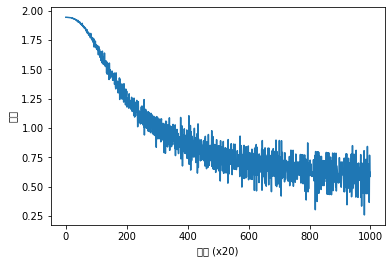

In [26]:
from common.trainer import Trainer
from common.optimizer import Adam

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [27]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [-1.1936911  1.1706418  1.1293805  1.196176   1.1148903]
say [ 1.222714   -0.22622086 -1.2009232  -1.1987523  -1.2216426 ]
goodbye [-0.6688501   0.89872265  0.75953215  0.66455936  0.7778855 ]
and [ 0.95932597 -1.9088417  -0.9941175  -0.96358985 -1.054018  ]
i [-0.6361736   0.87237036  0.75527316  0.64618725  0.7772974 ]
hello [-1.1976391  1.1880696  1.1357692  1.2096007  1.112962 ]
. [ 1.1174133  1.7617779 -1.0896955 -1.0458933 -1.0230821]


단어 분산 표현의 정밀도 면에서 skip-gram의 결과가 CBOW보다 우수한 경우가 많기 때문에 일반적으로 skip-gram을 사용한다. 특히, 말뭉치가 커질수록, 저빈도 단어나 유추 문제의 성능 면에서 skip-gram 모델이 더 뛰어난 경향이 있다. 반면, skip-gram은 loss를 맥락의 수만큼 구해야 해서 계산 비용이 커지기 때문에, 학습 속도의 면에서는 CBOW가 더욱 빠르다.   
간단히, 설명하자면, skip-gram이 주어진 중심 단어 하나만을 가지고 다양한 주변 단어를 예측하는 더욱 어려운 문제에 도전하기 때문에 더욱 어려운 상황에서 단련하는 만큼 그 결과로 표현되는 단어의 분산 표현이 더욱 뛰어날 가능성이 높은 것이다.